# Pose Estimation Related to Emotions

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import pandas as pd
from tools.detector import Detector
from tools.extractor import Extractor
from tools.metrics import label_probabilities, segmentate, normalize_segment, normalize_skeleton

/Users/deniskrylov/Developer/PosEmotion/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0


Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

# Uncomment the line below to extract frames from the videos
# extractor.extract_frames()

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a probability of a particular emotion, calculated as $i/n$, where $i$ is an emotion label and $n$ is a total number of emotions that were detected by different annotators.

In [4]:
df = label_probabilities(df)
df.head()

,Video Tag,Clip Id,Frame Number,X,Y,Width,Height,Person Id,Happy,Sad,Fear,Neutral,Surprise,Disgust,Anger
0,aJKL0ahn1Dk,1,19532,41.965200,4.873195,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,aJKL0ahn1Dk,1,19538,41.564836,4.874640,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,aJKL0ahn1Dk,1,19544,41.164472,4.876086,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aJKL0ahn1Dk,1,19550,40.764108,4.877532,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,aJKL0ahn1Dk,1,19556,39.646728,5.014136,44.216991,94.802684,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Extract Key Points

To extract keypoints, different approaches will be used such as YOLO-Pose, DeepPose and OpenPose. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

##### YOLO-Pose

In [5]:
def apply_yolo():    
    keypoints = []
    yolo_detector = Detector("models/yolo-pose.pt")

    for index, row in df.iterrows():
        try:
            result = yolo_detector.detect_poses("assets/frames/{}_{}.jpg".format(row["Video Tag"], index))
            keypoints.append(result.to_dict())
            print("Progress: {}/{}".format(index+1, len(df)))
        except:
            raise Exception("Error in detecting poses!")

    keypoints_df = pd.DataFrame(keypoints)
    keypoints_df.to_csv("/Users/deniskrylov/Developer/PosEmotion/assets/annotations/yolo_keypoints.csv", index=True)


# Uncomment the line below to apply YOLO to the frames
# apply_yolo()

yolo_df = pd.read_csv("/Users/deniskrylov/Developer/PosEmotion/assets/annotations/yolo_keypoints.csv")
yolo_df.head()

,nose_X,nose_Y,left_eye_X,left_eye_Y,right_eye_X,right_eye_Y,left_ear_X,left_ear_Y,right_ear_X,right_ear_Y,...,right_hip_X,right_hip_Y,left_knee_X,left_knee_Y,right_knee_X,right_knee_Y,left_ankle_X,left_ankle_Y,right_ankle_X,right_ankle_Y
0,803.315979,173.557571,835.515747,148.530548,783.055054,145.369812,879.411865,173.806686,757.570801,163.862640,...,695.001770,688.964600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,804.176758,173.216003,835.653809,147.682251,782.198486,145.796295,878.665039,173.041428,754.971069,165.978302,...,691.973938,694.487122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,805.239990,169.009888,836.457214,143.686768,782.505249,142.022675,877.768127,170.935852,753.729370,164.452728,...,695.380554,695.014038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,805.590393,172.032562,835.968811,146.862885,780.613586,146.146515,877.941833,173.451324,752.341492,171.449234,...,690.252319,686.663513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,787.117676,165.914810,817.990356,138.446503,763.025269,141.949539,868.388611,162.747101,740.108887,168.018570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



image 1/1 /Users/deniskrylov/Developer/PosEmotion/assets/frames/Bqb2wT_eP_4_266.jpg: 768x1280 2 persons, 1082.5ms
Speed: 2.6ms preprocess, 1082.5ms inference, 298.1ms postprocess per image at shape (1, 3, 768, 1280)
Keypoints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/Bqb2wT_eP_4_266.jpg
Nose: [824.4913330078125, 125.54843139648438]
Left Eye: [831.1438598632812, 113.58613586425781]
Right Eye: [810.8633422851562, 115.30799865722656]
Left Ear: [None, None]
Right Ear: [784.2180786132812, 122.82327270507812]
Left Shoulder: [859.3626708984375, 179.205322265625]
Right Shoulder: [745.9412841796875, 182.9040985107422]
Left Elbow: [896.89306640625, 248.85833740234375]
Right Elbow: [716.3466796875, 268.3713073730469]
Left Wrist: [910.7263793945312, 310.3706359863281]
Right Wrist: [766.7176513671875, 324.7613830566406]
Left Hip: [853.121826171875, 326.0069274902344]
Right Hip: [782.6707153320312, 332.6007080078125]
Left Knee: [942.9002685546875, 392.0818176269531]
Right Knee: 

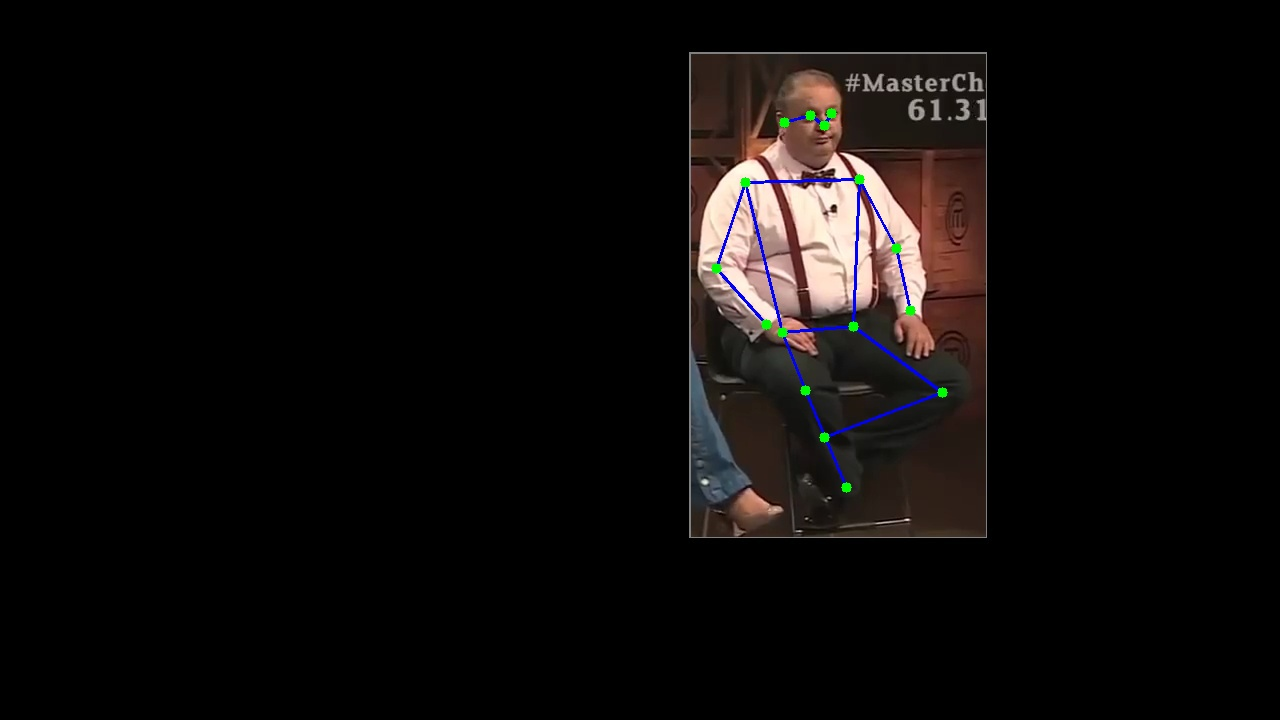

In [6]:
yolo_detector = Detector("models/yolo-pose.pt")
result = yolo_detector.detect_poses("assets/frames/Bqb2wT_eP_4_266.jpg")
print(result)
result.draw_ipython(False)

##### OpenPose

##### PoseFlow

### Normalization

##### Segment Normalization

- If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
- If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
- If the size of a segment $s = x$, then segment normalization won't be applied.

In [7]:
df = pd.read_csv("/Users/deniskrylov/Developer/PosEmotion/assets/annotations/yolo_annotations.csv")
segments = segmentate(df)
print("Total number of segments:", len(segments))
print("Original (first 5):", [segment.indices() for segment in segments][:5])

norm_segments = [normalize_segment(segment) for segment in segments]
norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)
norm_segments = segmentate(norm_df)
print("Total number of normalized segments:", len(norm_segments))
print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

Total number of segments: 630
Original (first 5): [(0, 27), (28, 39), (40, 51), (52, 69), (70, 77)]
Total number of normalized segments: 630
Normalized (first 5): [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49)]


##### Skeleton Normalization

According to [Romero Moralis](https://openaccess.thecvf.com/content_CVPR_2019/html/Morais_Learning_Regularity_in_Skeleton_Trajectories_for_Anomaly_Detection_in_Videos_CVPR_2019_paper.html), in 2D image space, $xy$-coordinates alone poorly repre- sent the real location in the scene because the depth is miss- ing. However, the size of a skeleton’s bounding box is correlated with the skeleton’s depth in the scene. To bridge this gap, the skeleton's bounding box can be used (that in our case was already given in dataset) with parameters $f^g = (x^g, y^g, w, h)$ and used to normalize the local components $f^{l,i} = (x^{l,i}, y^{l,i})$. 

In [10]:
box = (53.83828045035829, 7.238712612305235, 23.336745138178046, 67.50824519504147)
norm_result = normalize_skeleton(result, box)
print(norm_result)

Keypoints:
Image: /Users/deniskrylov/Developer/PosEmotion/assets/frames/Bqb2wT_eP_4_266.jpg
Nose: [33.023159313536596, 1.7525225021382882]
Left Eye: [33.308225924843306, 1.5753249539326475]
Right Eye: [32.43918795669295, 1.6008309167671728]
Left Ear: [None, None]
Right Ear: [31.297415035314792, 1.712154711751605]
Left Shoulder: [34.51742673104277, 2.5473423158383453]
Right Shoulder: [29.65722081769983, 2.6021323082967607]
Left Elbow: [36.1256370999521, 3.579112804546513]
Right Elbow: [28.389066055030213, 3.868158533913751]
Left Wrist: [36.71840669598503, 4.490294815073762]
Right Wrist: [30.547506376567704, 4.703465029004453]
Left Hip: [34.250001060084365, 4.721915285413802]
Right Hip: [31.23110916137702, 4.819588991766674]
Left Knee: [38.09708606920752, 5.700682989207886]
Right Knee: [32.20775817335704, 5.681386482002282]
Left Ankle: [33.04312012254153, 6.376429167899165]
Right Ankle: [33.96804155583975, 7.108263420865868]


## Step 2: Feature Extraction

### Pose Features

A detected skeleton will be divided into multiple groups of joints such as Right Leg, Left Leg, Right Hand, Left Hand, Torso and Head. For each group the following features will be computed:
- Average movement speed
- Acceleration
- Total travel distance of a curve
- Displacement: $(p_x, p_y) - (o_x, o_y)$
- Curvature (?)
- Entropy

### Dimensionality Reduction

- Principal Component Analysis

## Step 3: Clustering

### Hierarchical Clustering

## Step 4: Emotion Label Association

### Associate Poses with Emotions

## Step 5: Evaluation and Refinement

### Evaluate Clusters

### Refine Clusters